In [1]:
# Import libraries that are required to run your project
# You are allowed to add more libraries as you need

import os
import pandas as pd
import numpy as np
import torch.nn
from scipy.stats import spearmanr

## Work Package 1.1 - Modeling Choices & Data Pre-processing

In [ ]:
# TODO: 
# Load your feature (bed and/or bigwig and/or fasta) and target files (tsv) here.
# Decide which features to use for training. Feel free to process them however you need.

from utils.dataset import *
from torch.nn import AvgPool1d

# NOTE: 
# bed and bigwig files contain signals of all chromosomes (including sex chromosomes).
# Training and validation split based on chromosomes has been done for you. 
# However, you can resplit the data in any way you want.

#phils_path = "/home/phil/Downloads/ML4G_Project_1_Data"

path_data = "/home/phil/Downloads/ML4G_Project_1_Data"  # TODO
path_test = "/path/to/test/info/file"   # X3_test_info.tsv ; TODO
path_test = os.path.join(path_data, 'CAGE-train/CAGE-train/X3_test_info.tsv')
test_genes = pd.read_csv(path_test, sep='\t')
# ---------------------------INSERT CODE HERE---------------------------

# load gene information
train_info_X1 = pd.read_csv(os.path.join(path_data, 'CAGE-train', 'CAGE-train', 'X1_train_info.tsv'), sep='\t')
train_info_X2 = pd.read_csv(os.path.join(path_data, 'CAGE-train', 'CAGE-train', 'X1_train_info.tsv'), sep='\t')
print(f'Training Data Keys: {train_info_X1.keys()}')

# Modalities chosen by looking at the
modalities = ['DNase', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K36me3']
window_size = 20000

# prepare data (binning)
"""train_data_X1 = InputDataset(data_directory=path_data, cell_line='X1', objective="train", modality_names=modalities, window_size=window_size, only_bw=True, dim_reduction=AvgPool1d)

val_data_X1 = InputDataset(data_directory=path_data, cell_line='X1', objective="val", modality_names=modalities, window_size=window_size, only_bw=True, dim_reduction=AvgPool1d)

train_data_X2 = InputDataset(data_directory=path_data, cell_line='X2', objective="train", modality_names=modalities, window_size=window_size, only_bw=False)

val_data_X2 = InputDataset(data_directory=path_data, cell_line='X2', objective="val", modality_names=modalities, window_size=window_size, only_bw=False)"""
Bigwig_Matrix_Builder(data_directory='/home/phil/Downloads/ML4G_Project_1_Data', cell_line='X1', modality_names=modalities, window_size=20000, dim_reduction=True, num_bins=400, type='bw')
Bigwig_Matrix_Builder(data_directory='/home/phil/Downloads/ML4G_Project_1_Data', cell_line='X1', modality_names=modalities, window_size=20000, dim_reduction=True, num_bins=400, type='bw', val=True)
Bigwig_Matrix_Builder(data_directory='/home/phil/Downloads/ML4G_Project_1_Data', cell_line='X2', modality_names=modalities, window_size=20000, dim_reduction=True, num_bins=400, type='bw', val=True)
Bigwig_Matrix_Builder(data_directory='/home/phil/Downloads/ML4G_Project_1_Data', cell_line='X2', modality_names=modalities, window_size=20000, dim_reduction=True, num_bins=400, type='bw')
Bigwig_Matrix_Builder(data_directory='/home/phil/Downloads/ML4G_Project_1_Data', cell_line='X3', modality_names=modalities, window_size=20000, dim_reduction=True, num_bins=400, type='bw', objective='test')

# load_data
r = RegressionData(data_path='/home/phil/Downloads/ML4G_Project_1_Data', modalities=['DNase', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K36me3'], window_size=20000, num_bins=400, type='bw', cell_line='X1')
r2 = RegressionData(data_path='/home/phil/Downloads/ML4G_Project_1_Data', modalities=['DNase', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K36me3'], window_size=20000, num_bins=400, type='bw', cell_line='X2')
r3 = RegressionData(data_path='/home/phil/Downloads/ML4G_Project_1_Data', modalities=['DNase', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K36me3'], window_size=20000, num_bins=400, type='bw', cell_line='X3', objective='test')
# ---------------------------------------------------------------------- 

Training Data Keys: Index(['gene_name', 'chr', 'gene_start', 'gene_end', 'TSS_start', 'TSS_end',
       'strand'],
      dtype='object')
False


Loading DNase Matrix:  45%|██████▊        | 6462/14310 [00:17<00:19, 405.01it/s]

## Work Package 1.2 - Model Building

In [16]:
# TODO: 
# Select the best model to predict gene expression from the obtained features in WP 1.1.
import torch
import pytorch_lightning as pl

from utils.lightning_wrapper import ModelWrapper
from models.neural_nets import *
from sklearn.linear_model import LinearRegression

# ---------------------------INSERT CODE HERE---------------------------
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np
from scipy.stats import spearmanr


from utils.dataset import RegressionData
from utils.dataset import SimpleDataset
from models.neural_nets import BinnedConvolutionalModel
from utils.lightning_wrapper import ModelWrapper
from sklearn.linear_model import Lasso


# d1 = SimpleDataset(r.matrix, r.y)
# d2 = SimpleDataset(r.val_matrix, r.y_val)

d1 = SimpleDataset(np.vstack((r.matrix, r2.matrix)), np.concatenate((r.y, r2.y)))
d2 = SimpleDataset(np.vstack((r.val_matrix, r2.val_matrix)), np.concatenate((r.y_val, r2.y_val)))
#d = SimpleDataset(r.val_matrix, r.y_val)

stepsize = 1
data_indices = list(range(0, len(d1), stepsize))
sd1 = torch.utils.data.Subset(d1, data_indices)

data_indices = list(range(0, len(d2), stepsize))
sd2 = torch.utils.data.Subset(d2, data_indices)

"""model = BinnedConvolutionalModel()
lightning_model = ModelWrapper(model_architecture=model, learning_rate=1e-3, loss=torch.nn.L1Loss(), 
                               datasets=[sd1, sd2, sd2], batch_size=1)

trainer = pl.Trainer(max_epochs=10, deterministic=True,)# reload_dataloaders_every_n_epochs=5)
if torch.cuda.is_available():
    trainer.fit(lightning_model, accelerator="gpu")
else:
    trainer.fit(lightning_model)

p_dl = np.array(torch.cat(trainer.predict()))
"""

# --- Regression ---
clf = Lasso(alpha=541)
#clf.fit(np.vstack((r.matrix, r2.matrix)), np.concatenate((r.y[:-10], r2.y)))
clf.fit(d1.X, d1.y)
# clf.fit(new_X, r.y[:-10]+1)
p = clf.predict(d2.X)

print(spearmanr(p, d2.y))
#spearmanr((p_dl + p)/2, d2.y)

# -------------------
# AutoEncoder test

# TODO: do we need to normalize the data? Eg. by gene length? How is the groundtruth (y) given? Look at tutorial!
# ----------------------------------------------------------------------


SpearmanrResult(correlation=0.7319638384404596, pvalue=0.0)


Number of NaNs in matrix: 2361
Number of NaNs in matrix: 98


<AxesSubplot:>

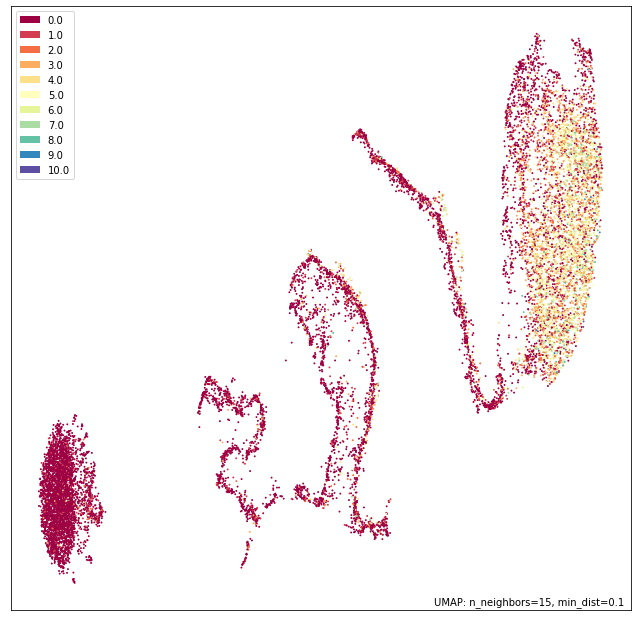

In [12]:
from utils.dataset import RegressionData
import umap
import umap.plot
import numpy as np
import math

r = RegressionData(data_path='/home/phil/Downloads/ML4G_Project_1_Data', modalities=['DNase', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K36me3'])

mapper = umap.UMAP().fit(r.matrix)

umap.plot.points(mapper, labels=np.ceil(np.log(r.y[:-10] + 1)))

##  Work Package 1.3 - Prediction on Test Data (Evaluation Metric)

In [5]:
# TODO:
# Using the model trained in WP 1.2, make predictions on the test data (chr 1 of cell line X3).
# Store predictions in a variable called "pred" which is a numpy array.

pred = None
# ---------------------------INSERT CODE HERE---------------------------
# pred = np.array(torch.cat(trainer.predict()))
pred = clf.predict(r3.matrix)

# ----------------------------------------------------------------------

# Check if "pred" meets the specified constrains
assert isinstance(pred, np.ndarray), 'Prediction array must be a numpy array'
assert np.issubdtype(pred.dtype, np.number), 'Prediction array must be numeric'
assert pred.shape[0] == len(test_genes), 'Each gene should have a unique predicted expression'

#### Store Predictions in the Required Format

In [6]:
# Store predictions in a ZIP. 
# Upload this zip on the project website under "Your submission".
# Zip this notebook along with the conda environment (and README, optional) and upload this under "Your code".

save_dir = '/home/phil/Downloads'  # TODO
file_name = 'gex_predicted.csv'         # PLEASE DO NOT CHANGE THIS
zip_name = "Toma_Philip_Project1.zip" # TODO
save_path = f'{save_dir}/{zip_name}'
compression_options = dict(method="zip", archive_name=file_name)

test_genes['gex_predicted'] = pred.tolist()
test_genes[['gene_name', 'gex_predicted']].to_csv(save_path, compression=compression_options)